<a href="https://colab.research.google.com/github/rjy1022/my_assets/blob/main/Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Aspects of this notebook have been adapted from the Neuromatch course materials [here](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/README.md).*

In [ ]:
#import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.optimize import minimize
from scipy.optimize import fsolve
import pandas as pd

#importing dimensionality reduction packages
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import MDS
from sklearn.manifold import Isomap 
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
import umap

#importing clustering packages
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [ ]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

## Model selection

Today, we will be looking at model selection -- how to select an individual model out of a set of many potential options.  The goal is to select a model that not only describes the data that we have, but also the the data that we would expect to get if we were to either collect more or to repeat the experiment.  This process forces us to confront many of the key trade-offs that we have seen so far in class.  These include representation vs. fidelity, incorporating new information vs. trusting prior knowledge, and a new trade-off: bias vs. variance.  We will start here. 

---
##Bias-variance tradeoff

**Test Set** is the portion of a data set that you use to fit a given model.  These data are used to find best-fit parameters, $\theta$, or, more generally, the posterior distribution $p(\theta\vert \vec{x})$.

**Training Set** is the portion of a data that is held-aside during the fitting procedure and is used to assess how the model generalizes to new data.

**Bias** is the difference between the prediction of the model and the "true" output variables that you are trying to predict. Models with high bias will not fit the training set data well, since the predictions are quite different from the true process generating the data. These high bias models are overly simplified - they do not have enough parameters and complexity to accurately capture the patterns in the data (*underfitting*).


**Variance** refers to the variability of model predictions across different data samples. Essentially, do the model predictions change a lot with changes in the exact training data used? Models with high variance are highly dependent on the exact training data used - they will not generalize well to test data (*overfitting*).

* High bias, low variance models have high train and test error.
* Low bias, high variance models have low train error, high test error
* Low bias, low variance models have low train and test error
* High bias, high variance models should just be avoided

Having a low bias and a high variance are typically in conflict though - models with enough complexity to have low bias also tend to overfit and depend on the training data more. We need to decide on the correct tradeoff.

In this section, we will see the bias-variance tradeoff in action with polynomial regression models of different orders.

Graphical illustration of bias and variance.
(Source: http://scott.fortmann-roe.com/docs/BiasVariance.html)

![bias-variance](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/bias_variance/bullseye.png) 


##An Example: Fitting Polynomials

A typical exersize in data analysis is to fit a polynomial to a data set.  Computing this fit is typically straight-forward (in python, you can use [```np.polyfit()```](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)), regardless of the order of the polynomial.  However, selecting how many orders is the "best" is often rather challenging without using a formal methodology like Bayesian model selection.

We will start with a case where we know the answer already, data that is generated from the function $y = f(x) = 0.1x^2 + 0.5x + 2 + \mathcal{N}(0,\sigma^2)$, where $\mathcal{N}(0,\sigma^2)$ is a Gaussian random variable with mean of $0$ and standard deviation $\sigma$.

<font color="blue">Question #1: Write a function, ```output_quadratic(x,sigma)```, where ```x``` is a numpy array of input values, ```sigma``` is the noise standard deviation, and the function returns ```y```, the output of applying the equation above to ```x``` (assume that the noise is independent for each value of ```x```). </font>

In [ ]:
#Write code for Question #1 here:
def output_quadratic(x,sigma):
  fx = (.1 * (x) ** 2) + (.5 * x) + 2 + random.normal(0, sigma, size=np.shape(x))
  return fx

<font color="blue">Question #2: For $\sigma = 1$, fit and plot outputs of your function above to a linear, a quadratic, and a cubic polynomial using ```p = np.polyfit(x,y,order)```, where ```x=np.arange(-5,5,.1)``` and plot the outputs.  Compare the mean-squared-errors for all three fits (you can use [```np.polyval()```](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html)).  Which fit has the lowest mean squared error?  Does this answer surprise you? Why or why not?</font>

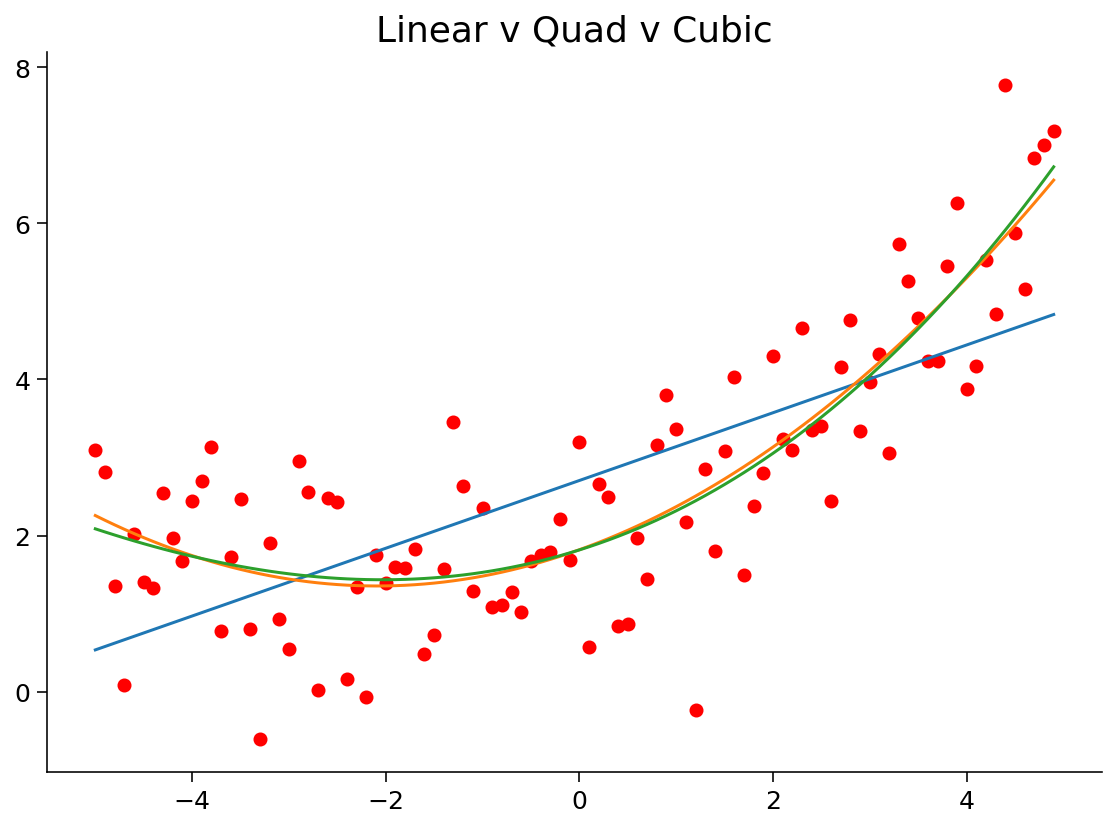

147.86346644310373 84.95656411518232 84.48936435388772


In [ ]:
#Write code for Question #2 here:
x = np.arange(-5,5,.1)
y = output_quadratic(x,1)
linear = np.polyfit(x,y,1)
quad = np.polyfit(x,y,2)
cubic = np.polyfit(x,y,3)

y_linear = linear[0] * x + linear[1]
y_quad = quad[0] * (x ** 2) + quad[1] * (x) + quad[2]
y_cubic = cubic[0] * (x ** 3) + cubic[1] * (x ** 2) + cubic[2] * (x) + cubic[3]

plt.plot(x, y, "ro")
plt.plot(x, y_linear)
plt.plot(x, y_quad)
plt.plot(x, y_cubic)
plt.title("Linear v Quad v Cubic")
plt.show()

lin_ms = sum((y_linear - y) ** 2)
lin_q = sum((y_quad - y) ** 2)
lin_c = sum((y_cubic - y) ** 2) 

print(lin_ms, lin_q, lin_c)

<font color="green"> Which fit has the lowest mean squared error?  Does this answer surprise you? Why or why not? 

The cubic fit. This is surprising because we generated the data using a quadratic function. </font>

<font color="blue"> Question #3: Now, regenerate ```y``` 10,000 times using your function from Question #1 (still, $\sigma = 1$) and fit a quadratic polynomial to a training set that consists of a random 90% of the values (90 points out of 100).  Save the fitted parameter values, the training set mean-squared-error (MSE), and the test set MSE each time.  Plot histograms for the two MSEs.  Is your training or test MSE higher?  Why is this?  Do the parameter estimates appear biased to you? (Remember: the model generating the data is $y = f(x) = 0.1x^2 + 0.5x + 2 + \mathcal{N}(0,\sigma^2)$)

121.11178736087044
11.908064767277978


(array([  4.,  12.,  29.,  50.,  55.,  61., 109., 123., 148., 188., 215.,
        216., 259., 289., 287., 323., 346., 322., 373., 388., 373., 373.,
        317., 307., 336., 319., 290., 296., 245., 250., 215., 218., 240.,
        189., 205., 181., 169., 152., 143., 130., 105.,  99., 111.,  92.,
         78.,  81.,  64.,  72.,  49.,  44.,  45.,  50.,  30.,  40.,  31.,
         31.,  20.,  28.,  18.,  20.,   9.,  16.,  16.,  13.,  11.,   7.,
          4.,  11.,   8.,   7.,   8.,   8.,   3.,   4.,   4.,   6.,   0.,
          0.,   3.,   3.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([ 1.0560218 ,  1.42144575,  1.78686971,  2.15229366,  2.51771761,
         2.88314157,  3.24856552,  3.61398948,  3.97941343,  4.34483738,
         4.71026134,  5.07568529,  5.44110924,  5.8065332 ,  6.17195715,
         6.53738111,  6.90280506,  7.26822901,  7.63365297,  7.99907692,
         8.36450088,  8.72

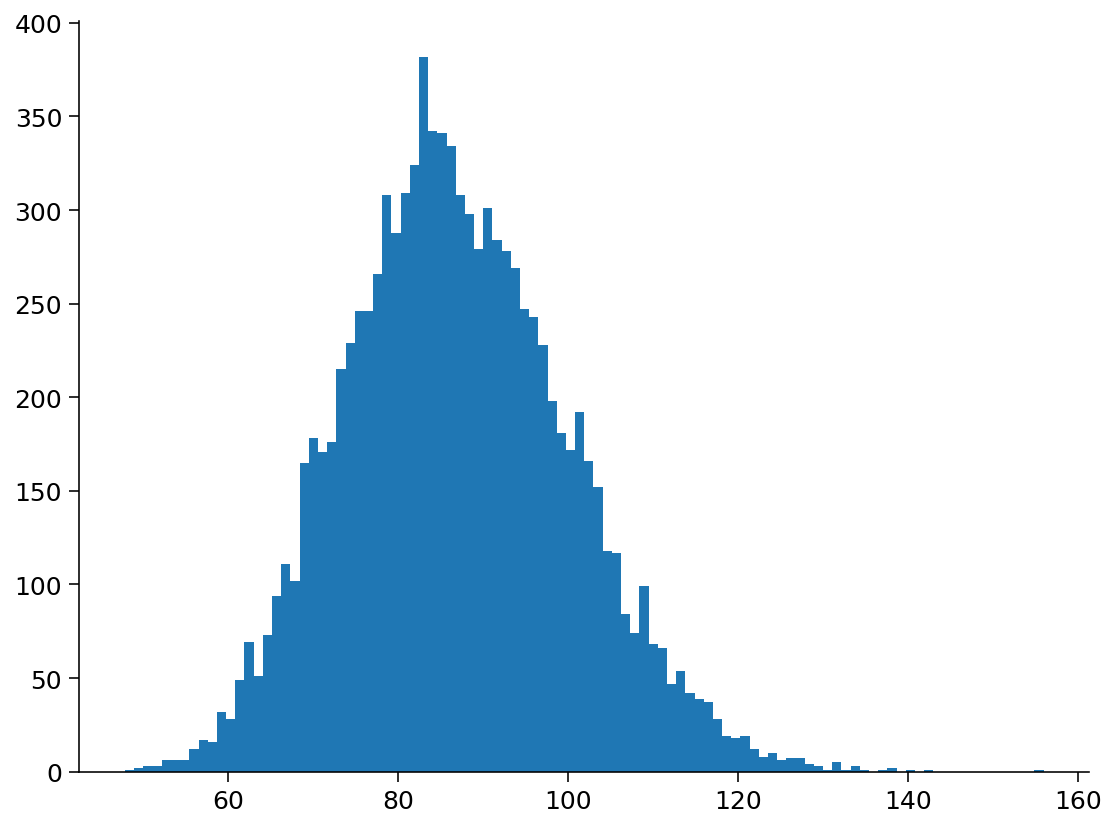

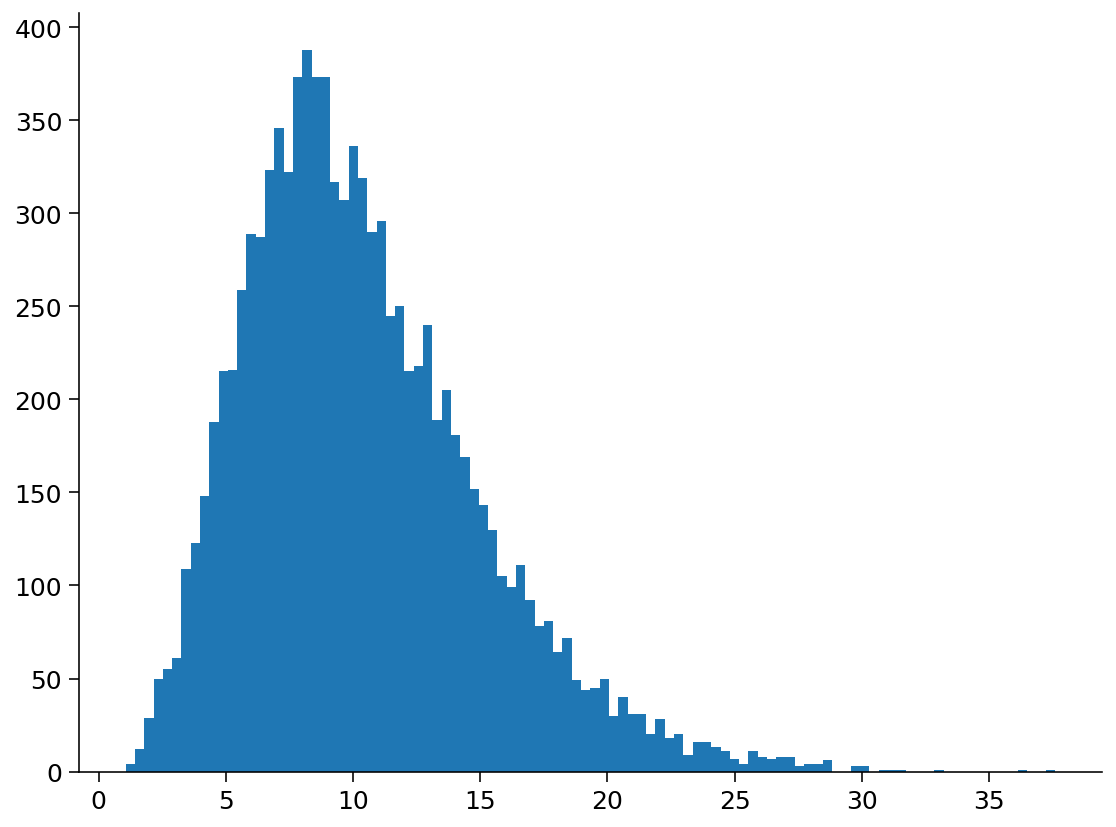

In [ ]:
#Type your code for Question #3 here
x = np.arange(-5,5,.1)
sigma = 1
L = 90
test_mses = []
train_mses = []
for i in range(10000):
  y = output_quadratic(x,sigma)
  idx = np.arange(np.shape(x)[0])
  random.shuffle(idx) 
  x_train = x[idx[:L]]
  y_train = y[idx[:L]]
  x_test = x[idx[L:]]
  y_test = y[idx[L:]]

  quad = np.polyfit(x_train,y_train,2)
  quad_y = np.polyval(quad, x_train)
  train_mse = sum((quad_y - y_train) ** 2)
  train_mses.append(train_mse)

  quad_test_y = np.polyval(quad, x_test)
  test_mse = sum((quad_test_y - y_test) ** 2)

  test_mses.append(test_mse)

print(np.mean(train_mse))
print(np.mean(test_mse))
plt.hist(train_mses, bins=100)
plt.figure()
plt.hist(test_mses, bins=100)

<font color="green"> Is your training or test MSE higher?  Why is this?  Do the parameter estimates appear biased to you?

The training MSE is higher. This is not what we initially expected, but after thinking about it, it makes sense. We have 90% of the values in the training set and only 10% in the test set. This means we have more chance for the noise to add up and appear as error, about 9x chance, which is the difference between our training and test MSE. The parameter estimates are not biased because we have the right model.</font>

<font color="blue"> Question #4: Repeat Question #3, but with cubic fits instead of quadratic fits.  Compare the means and variances of the training and test set MSEs with those that you got from the quadratic fits.  Based on these results, which fit would you pick (pretend that you don't know the answer)?  Justify your answer.

103.23169154163047
13.152449520904888


(array([  7.,  11.,  22.,  57.,  89., 109., 141., 183., 189., 264., 255.,
        300., 315., 340., 371., 360., 379., 361., 368., 385., 379., 348.,
        347., 322., 332., 271., 283., 254., 237., 226., 216., 221., 213.,
        167., 151., 148., 127., 134., 115.,  98., 101.,  99.,  69.,  72.,
         68.,  47.,  48.,  60.,  49.,  34.,  27.,  21.,  29.,  29.,  20.,
         17.,  20.,   6.,  15.,   7.,  10.,   7.,  10.,   8.,   9.,   4.,
          3.,   0.,   5.,   1.,   1.,   2.,   1.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 1.14203948,  1.54392228,  1.94580508,  2.34768788,  2.74957067,
         3.15145347,  3.55333627,  3.95521907,  4.35710186,  4.75898466,
         5.16086746,  5.56275026,  5.96463305,  6.36651585,  6.76839865,
         7.17028144,  7.57216424,  7.97404704,  8.37592984,  8.77781263,
         9.17969543,  9.58

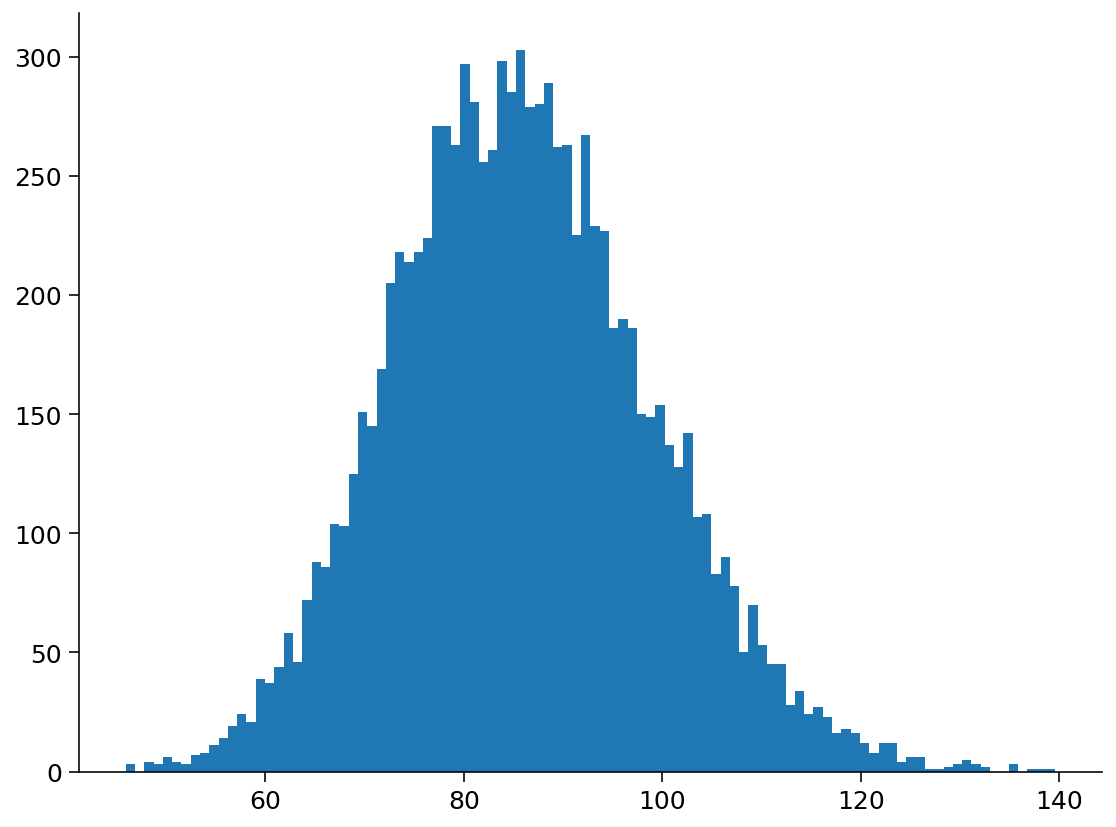

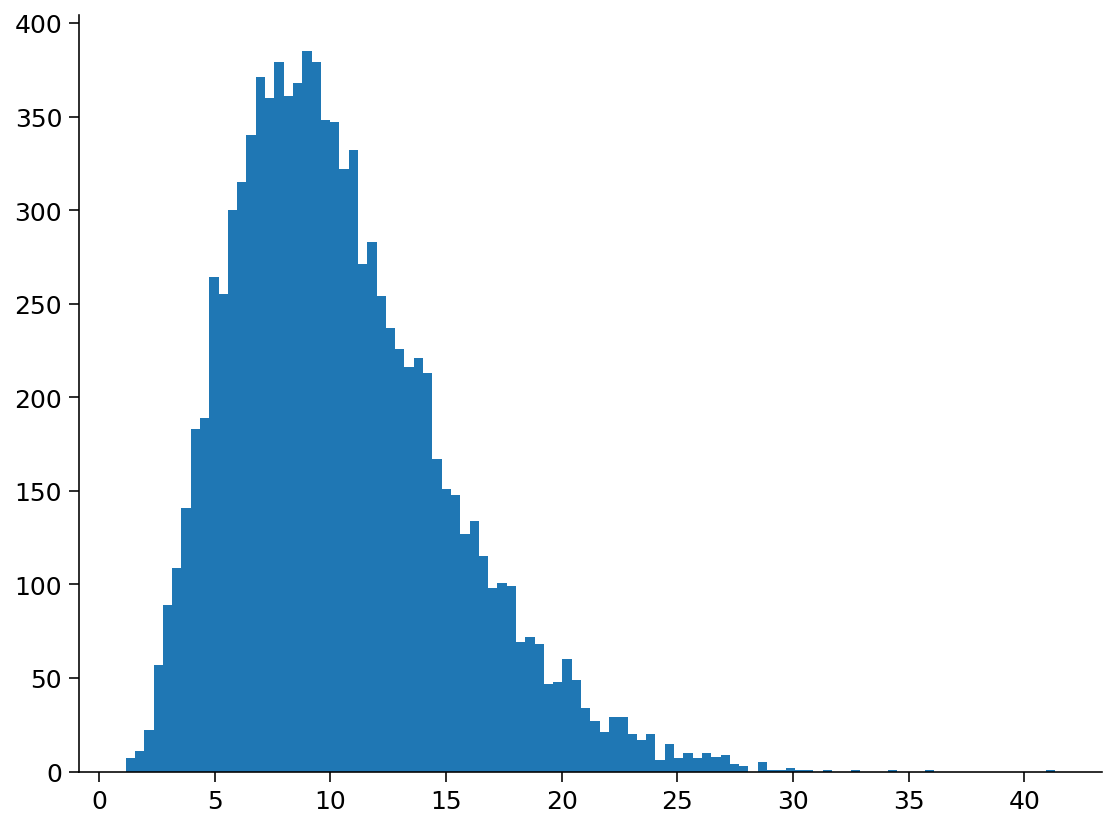

In [ ]:
#Type your code for Question #3 here
x = np.arange(-5,5,.1)
sigma = 1
L = 90
test_mses = []
train_mses = []
for i in range(10000):
  y = output_quadratic(x,sigma)
  idx = np.arange(np.shape(x)[0])
  random.shuffle(idx) 
  x_train = x[idx[:L]]
  y_train = y[idx[:L]]
  x_test = x[idx[L:]]
  y_test = y[idx[L:]]

  cubic = np.polyfit(x_train,y_train,3)
  cubic_y = np.polyval(cubic, x_train)
  train_mse = sum((cubic_y - y_train) ** 2)
  train_mses.append(train_mse)

  cubic_test_y = np.polyval(cubic, x_test)
  test_mse = sum((cubic_test_y - y_test) ** 2)

  test_mses.append(test_mse)

print(np.mean(train_mse))
print(np.mean(test_mse))
plt.hist(train_mses, bins=100)
plt.figure()
plt.hist(test_mses, bins=100)

<font color="green"> Compare the means and variances of the training and test set MSEs with those that you got from the quadratic fits. Based on this information, which fit would you pick (pretend that you don't know the answer)? Justify your answer.

We would pick the cubic equation as it has a lower avg MSE.</font>

<font color="blue">Question #5: Plot the mean and standard deviation for the test and training MSEs for polynomial fits from order 1 to 10 ($\sigma = 1$, still).  For the sake of time, you can reduce the number of instantiations per polynomial to 1,000 instead of 10,000.  Based on these results, which order would you pick?  Why?  Does this agree with the correct result?  Discuss your results in light of the bias-variance trade-off. (You can use [```plt.errorbar()```](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html) to make your plots).</font>

1 mean: Test - 15.788831462698724 | Train - 137.8615735410295
   std: Test - 6.797065900827501 | Train - 18.901074624021785
2 mean: Test - 10.12893090087719 | Train - 87.44396687365594
   std: Test - 4.554081736923614 | Train - 13.141023881263806
3 mean: Test - 10.509873035566278 | Train - 85.7128665682514
   std: Test - 4.6011479320693685 | Train - 12.875036644095912
4 mean: Test - 10.545015636949213 | Train - 84.99511671029013
   std: Test - 4.963197553872623 | Train - 13.258896903384834
5 mean: Test - 10.883205630539852 | Train - 84.4416465311814
   std: Test - 4.935976788340666 | Train - 12.668480030527745
6 mean: Test - 11.00754404530628 | Train - 82.80764157582684
   std: Test - 4.850137466182796 | Train - 12.717129973677789
7 mean: Test - 10.966065085658212 | Train - 82.16451980677915
   std: Test - 5.163415356836994 | Train - 12.823767012394606
8 mean: Test - 11.18355659464934 | Train - 81.24702916942383
   std: Test - 5.419511753194592 | Train - 13.00445172604142
9 mean: Test 

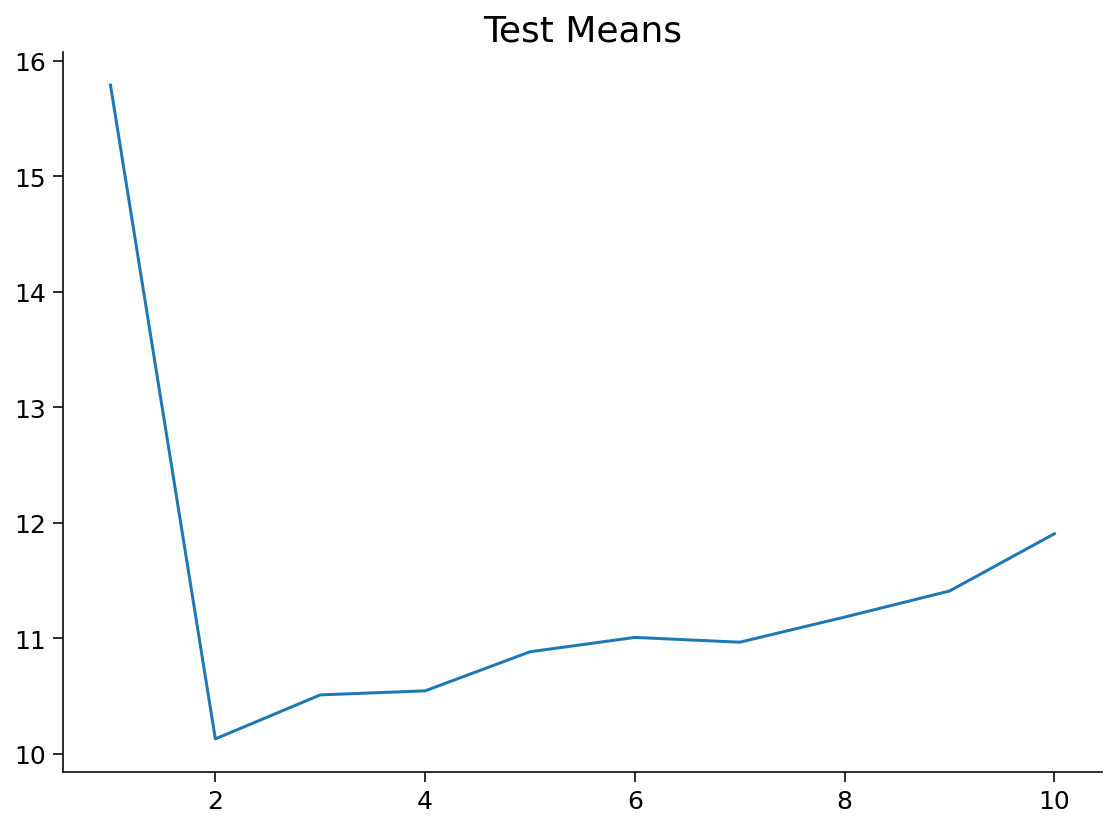

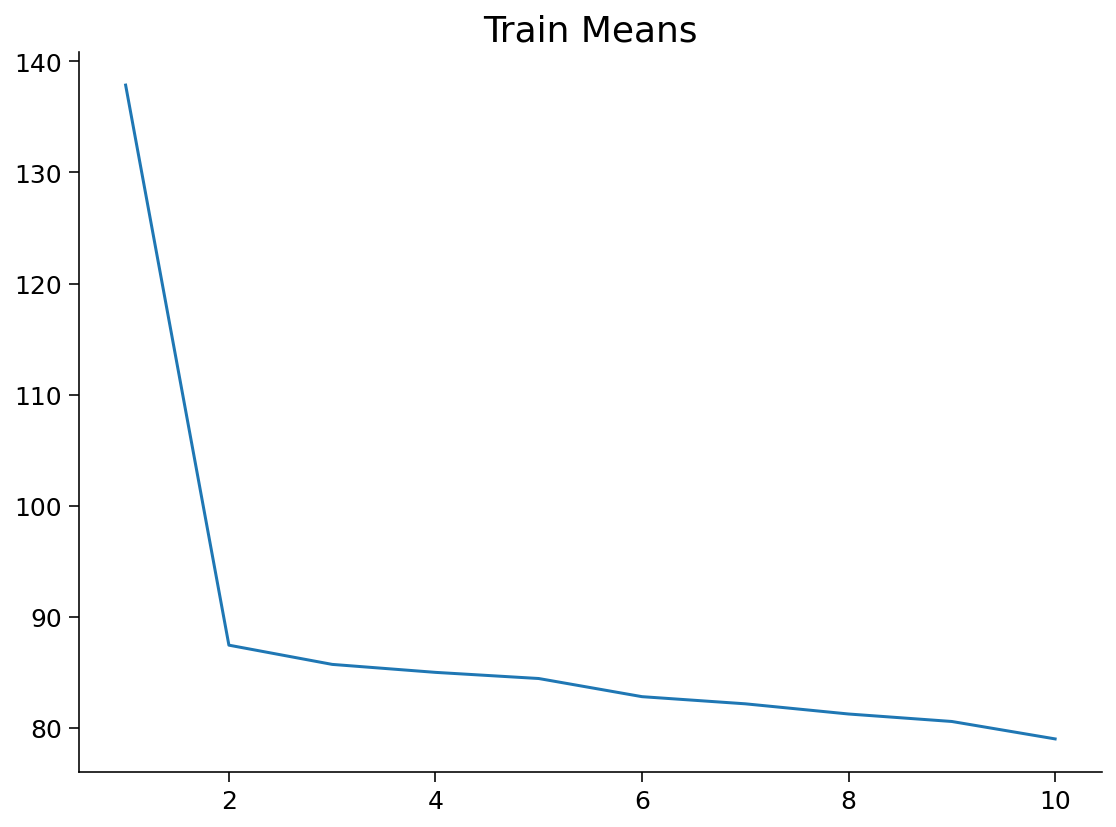

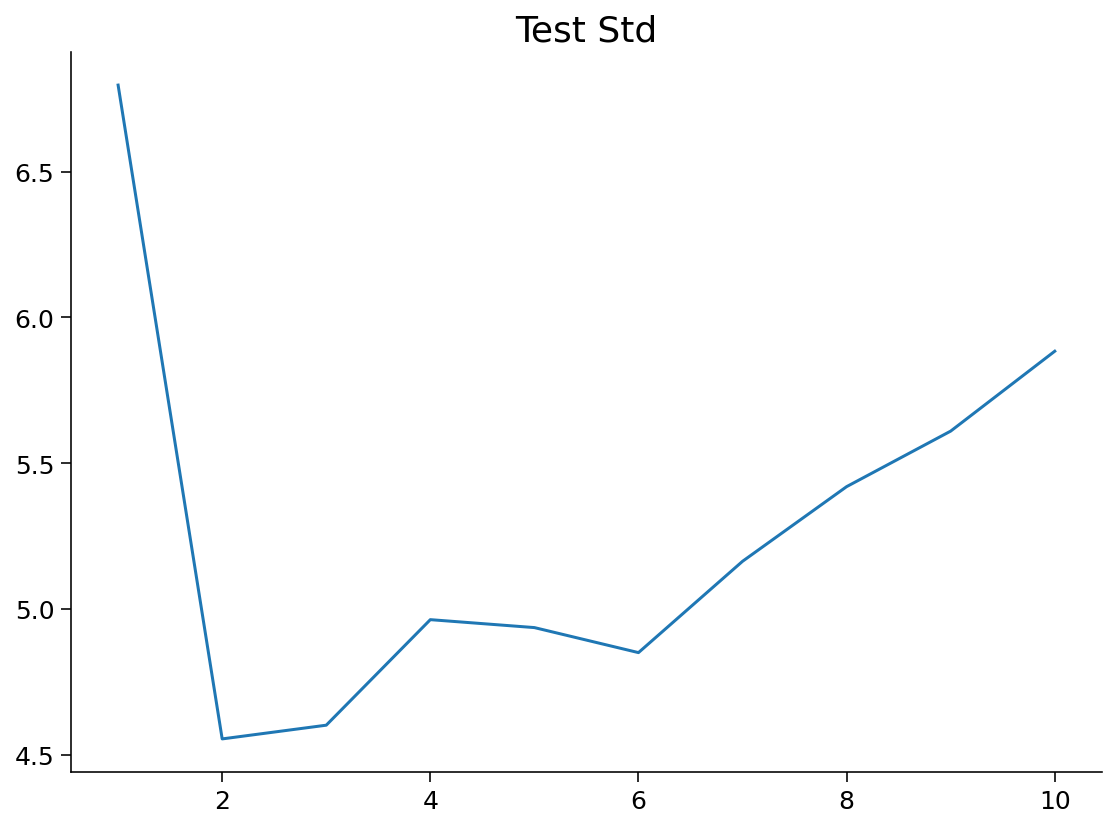

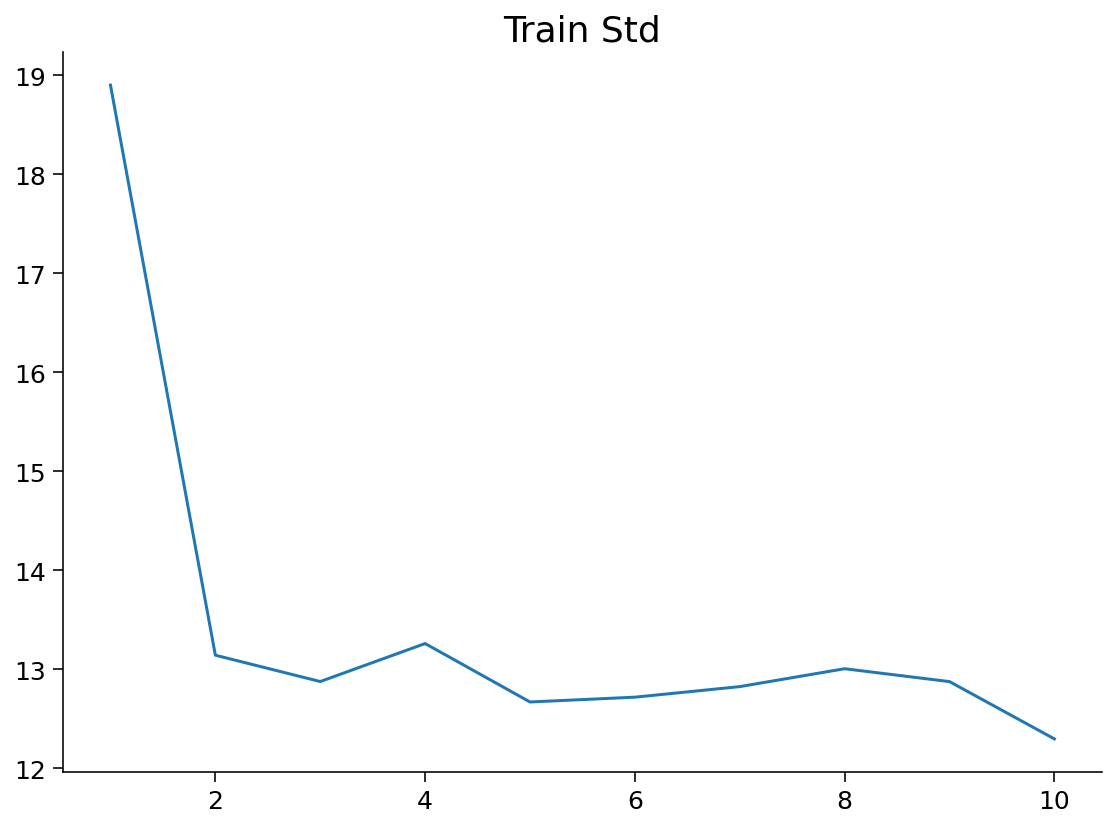

In [ ]:
#Type your code for Question #3 here

fit_mses = []
for fit in range(1, 11):
  x = np.arange(-5,5,.1)
  sigma = 1
  L = 90
  test_mses = []
  train_mses = []
  for i in range(1000):
    y = output_quadratic(x,sigma)
    idx = np.arange(np.shape(x)[0])
    random.shuffle(idx) 
    x_train = x[idx[:L]]
    y_train = y[idx[:L]]
    x_test = x[idx[L:]]
    y_test = y[idx[L:]]

    cubic = np.polyfit(x_train,y_train,fit)
    cubic_y = np.polyval(cubic, x_train)
    train_mse = sum((cubic_y - y_train) ** 2)
    train_mses.append(train_mse)

    cubic_test_y = np.polyval(cubic, x_test)
    test_mse = sum((cubic_test_y - y_test) ** 2)

    test_mses.append(test_mse)

  fit_mses.append((test_mses, train_mses))

test_means = []
train_means = []
test_sds = []
train_sds = []
for i, vals in enumerate(fit_mses):
  test, train = vals
  test_mean = np.mean(test)
  train_mean = np.mean(train)
  test_means.append(test_mean)
  train_means.append(train_mean)

  test_sd = np.std(test)
  train_sd = np.std(train)
  test_sds.append(test_sd)
  train_sds.append(train_sd)

  print("{} mean: Test - {} | Train - {}".format(i+1,test_mean, train_mean))
  print("   std: Test - {} | Train - {}".format(test_sd, train_sd))

x_s = np.arange(1,11)
plt.errorbar(x_s, test_means)
plt.title("Test Means")
plt.figure()
plt.errorbar(x_s, train_means)
plt.title("Train Means")
plt.figure()
plt.errorbar(x_s, test_sds)
plt.title("Test Std")
plt.figure()
plt.errorbar(x_s, train_sds)
plt.title("Train Std")
plt.show()




<font color="green"> Based on these results, which order would you pick? Why? Does this agree with the correct result? Discuss your results in light of the bias-variance trade-off.

Quadratic. It has the around the same bias, as well as the lowest variance. This does agree with the correct result. When we look at more complex models (ie higher-order fits), we see that the training error decreases, but the test error gets higher. This reflects the increase in variance as model complexity increases that we would expect to see. </font>

<font color="blue"> Question #6: Repeat the previous question but for $\sigma = 5$.  How do you results change?  Why do you think these effects are occurring?

1 mean: Test - 265.3584686833959 | Train - 2237.442459901334
   std: Test - 116.92715939229697 | Train - 356.91466359834243
2 mean: Test - 262.3310778317331 | Train - 2198.5908364359307
   std: Test - 117.51940588805277 | Train - 341.1496392784055
3 mean: Test - 262.1266717027748 | Train - 2164.539564020764
   std: Test - 117.25960126859187 | Train - 325.13900073874635
4 mean: Test - 263.8507570606936 | Train - 2125.3036877033765
   std: Test - 120.79567333146846 | Train - 316.7947227437021
5 mean: Test - 272.7946375520507 | Train - 2109.7075136935973
   std: Test - 127.81429113311606 | Train - 327.9652939720949
6 mean: Test - 276.96803791090156 | Train - 2081.030505320931
   std: Test - 124.61627637141105 | Train - 321.787514860844
7 mean: Test - 278.8382554440919 | Train - 2046.9495513284378
   std: Test - 129.65962086701356 | Train - 316.6766150348542
8 mean: Test - 283.48221416270803 | Train - 2046.2637380073297
   std: Test - 132.02016931135148 | Train - 320.9559230781747
9 mean: 

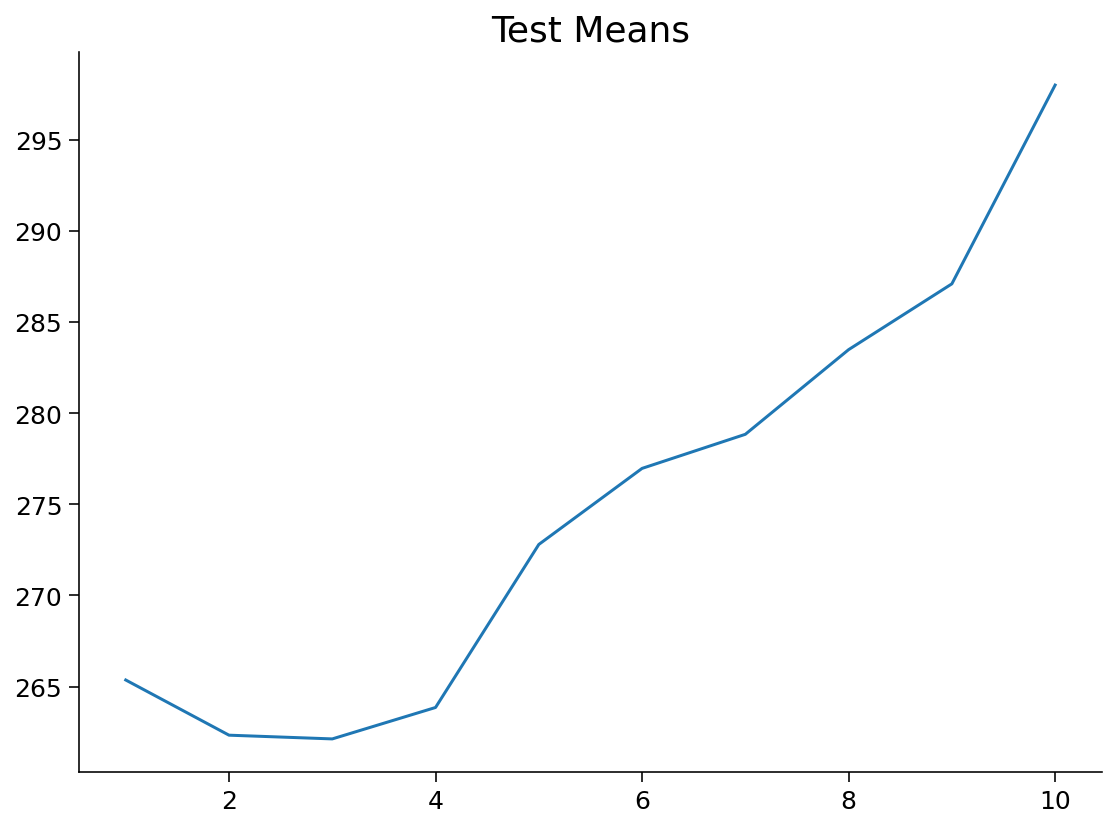

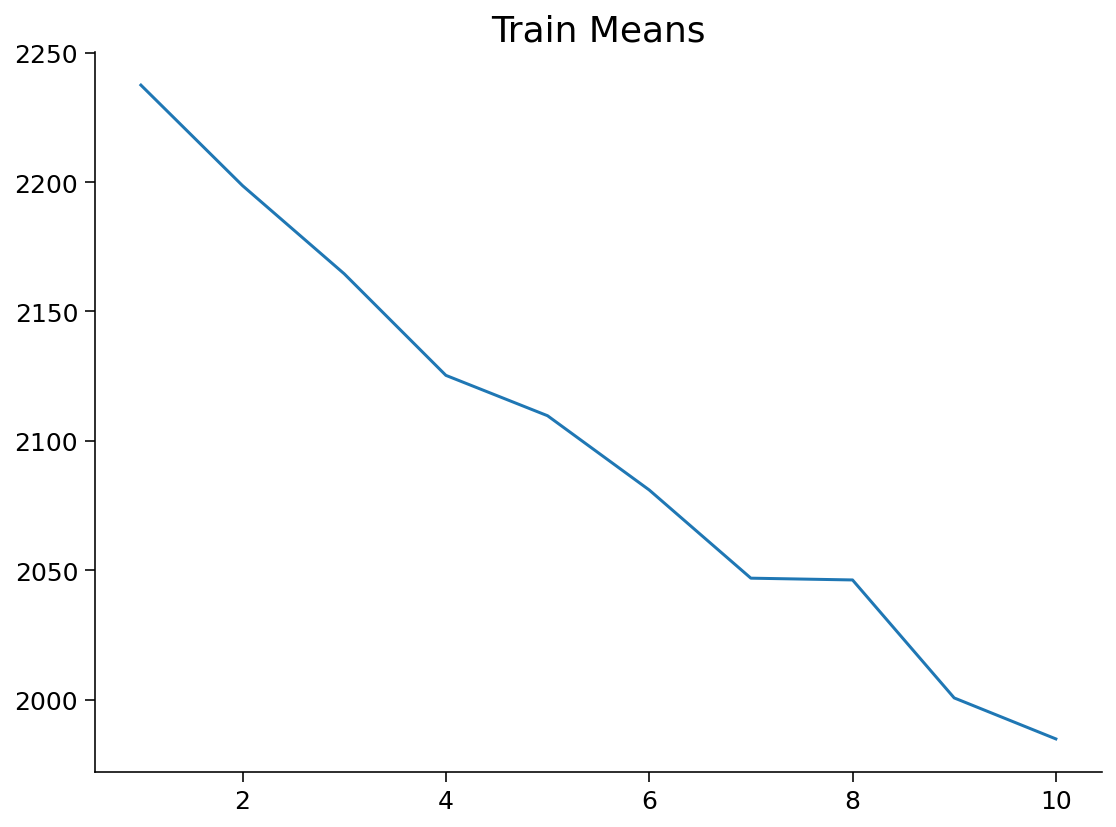

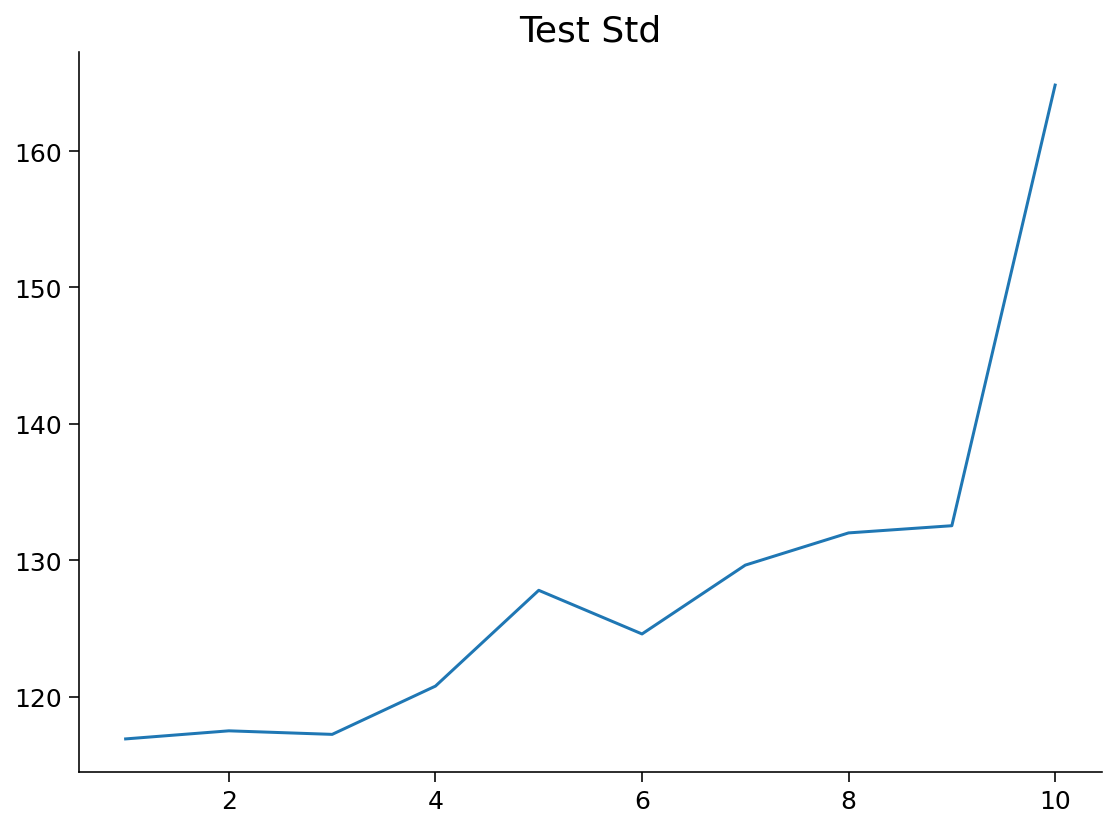

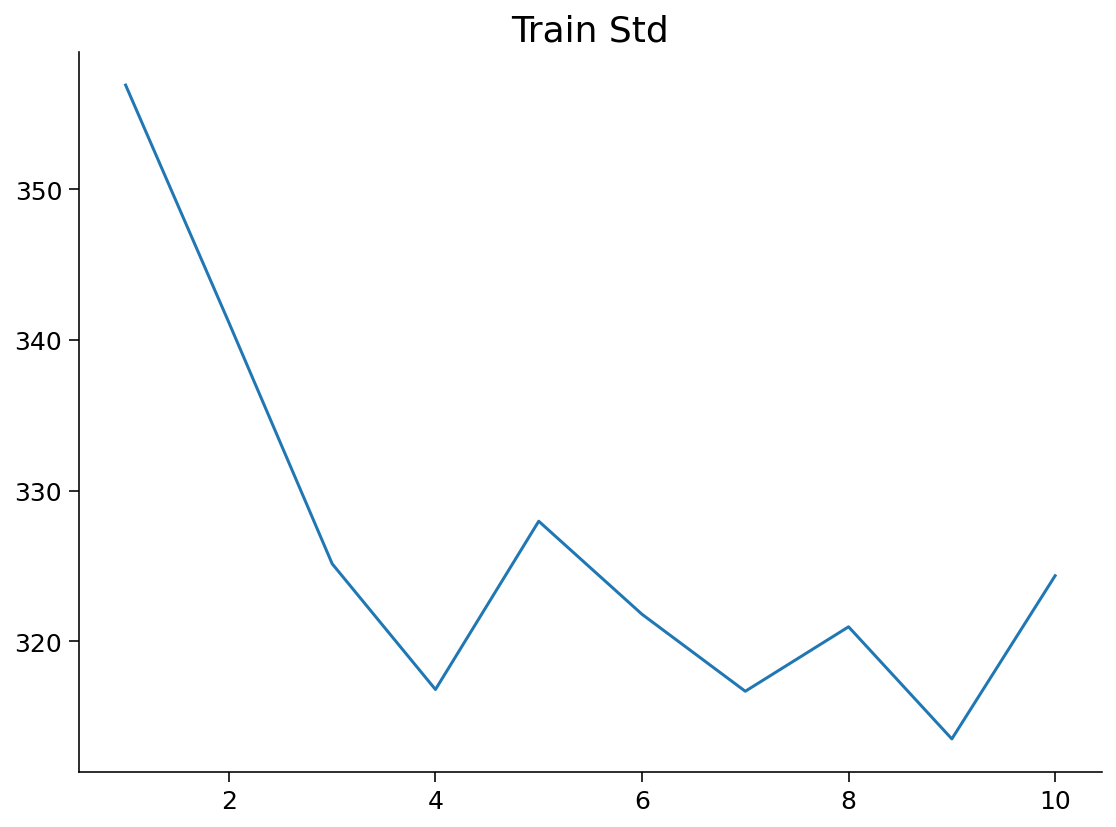

In [ ]:
fit_mses = []
for fit in range(1, 11):
  x = np.arange(-5,5,.1)
  sigma = 5
  L = 90
  test_mses = []
  train_mses = []
  for i in range(1000):
    y = output_quadratic(x,sigma)
    idx = np.arange(np.shape(x)[0])
    random.shuffle(idx) 
    x_train = x[idx[:L]]
    y_train = y[idx[:L]]
    x_test = x[idx[L:]]
    y_test = y[idx[L:]]

    cubic = np.polyfit(x_train,y_train,fit)
    cubic_y = np.polyval(cubic, x_train)
    train_mse = sum((cubic_y - y_train) ** 2)
    train_mses.append(train_mse)

    cubic_test_y = np.polyval(cubic, x_test)
    test_mse = sum((cubic_test_y - y_test) ** 2)

    test_mses.append(test_mse)

  fit_mses.append((test_mses, train_mses))

test_means = []
train_means = []
test_sds = []
train_sds = []
for i, vals in enumerate(fit_mses):
  test, train = vals
  test_mean = np.mean(test)
  train_mean = np.mean(train)
  test_means.append(test_mean)
  train_means.append(train_mean)

  test_sd = np.std(test)
  train_sd = np.std(train)
  test_sds.append(test_sd)
  train_sds.append(train_sd)

  print("{} mean: Test - {} | Train - {}".format(i+1,test_mean, train_mean))
  print("   std: Test - {} | Train - {}".format(test_sd, train_sd))

x_s = np.arange(1,11)
plt.errorbar(x_s, test_means)
plt.title("Test Means")
plt.figure()
plt.errorbar(x_s, train_means)
plt.title("Train Means")
plt.figure()
plt.errorbar(x_s, test_sds)
plt.title("Test Std")
plt.figure()
plt.errorbar(x_s, train_sds)
plt.title("Train Std")
plt.show()

<font color="green"> How do you results change?  Why do you think these effects are occurring? 

Increasing sigma increases the noise added onto our original data, making selecting the correct model complexity more difficult, as the results aren't quite as clear. For example, a polynomial order 5 would, according to the above results, fit our data with quite low bias and relatively low variance as well. Therefore, we may end up modeling noise instead of the true underlying phenomenon.</font>

##Estimating errors and maximum likelihood

Mean-squared-error, while a useful measure, doesn't fit directly into a Bayesian framework, which is based purely on probabilities.  For this, we need to translate MSE into a *likelihood* -  $p(\text{Data}\vert\text{Model})$, which we will call $p(X\vert \mathcal{M},\theta)$.  This is done by assuming that the data we see is generated from a true underlying model and is then corrupted by a noise distribution that we know.  We can also make our lives easier by assuming that each data point is arrived at independently. Thus, our likelihood is aproximated by:
\begin{equation}
p(X\vert \mathcal{M},\theta) \approx p(x_1\vert \mathcal{M},\theta)p(x_2\vert \mathcal{M},\theta)\ldots p(x_N\vert \mathcal{M},\theta) = \prod_{i=1}^N p(x_i\vert \mathcal{M},\theta),
\end{equation}
where each $x_i\in X$ is a seperate data point.  Or, if we write this in terms of the log-likelihood, $\mathcal{L}(X\vert \mathcal{M},\theta)$,
\begin{equation}
\mathcal{L}(X\vert \mathcal{M},\theta) \approx \log p(x_1\vert \mathcal{M},\theta)+\log p(x_2\vert \mathcal{M},\theta) + \ldots + \log p(x_N\vert \mathcal{M},\theta) = \sum_{i=1}^N \log p(x_i\vert \mathcal{M},\theta),
\end{equation}

Although the distribution $p(x_i\vert \mathcal{M},\theta)$ could have many potential forms, due ot the central limit theorem, the most common form for this is a gaussian distribution centered around our model's estimate, $\hat{f}(x_i\vert \mathcal{M},\theta)$:
\begin{equation}
p(x_i\vert \mathcal{M},\theta) = \frac{1}{\sqrt{2\pi \hat{\sigma}^2}}\exp \left [\frac{-(x_i-\hat{f}(x_i\vert \mathcal{M},\theta)^2}{2\hat{\sigma}^2} \right],
\end{equation}
where $\hat{\sigma}^2$ is the measured mean-squared error of the fit.

It should be noted that the mean-squared error often isn't a good assumption in the case of high-bias/low-variance models that underfit the data (e.g., the linear fit back in Question #1), but it is a good assumption when comparing models that don't obviously under-fit the data.

Nonetheless, if we plug this definition into the previous equation (and play around with logrithms and exponentials), we find that:
\begin{equation}
\mathcal{L}(X\vert \mathcal{M},\theta) = \sum_{i=1}^N \log p(x_i\vert \mathcal{M},\theta) = -\frac{N}{2}\log(2\pi\hat{\sigma}^2) - \frac{N}{2}.
\end{equation}
Thus, as our MSE ($\hat{\sigma}^2$) decreases, $\mathcal{L}(X\vert \mathcal{M},\theta)$ increases, as the likelihood becomes less negative.  Thus, minimizing MSE and maximizing likelihood are equivalent!

<font color=blue>Question #7: Write a function, ```calculateLikelihood(x,y,order)```, that fits a polynomial of order ```order``` to numpy arrays ```x``` and ```y``` and returns the likelihood of generating the observed data given the fitted model (using the equation above).</font>

In [ ]:
#Write code for Question #7 here
def calculateLikelihood(x,y,order):
  result = np.polyfit(x, y, order)
  vals = np.polyval(result, x)
  mse = np.mean((vals - y) ** 2)
  
  nd = len(x) / 2
  log_lik = -1 * nd * np.log(2 * np.pi * mse) - nd
  return log_lik


<font color=blue>Question #8: Use your functions from Questions #1 and #7 to calculate the likelihoods for polynomial fits from order 1 to 10 for a single instantiation of the data.  Use ```x=np.arange(-5,5,.1)``` and $\sigma=1$.  Based soley on the likelihood, which model would you pick?  Why?</font>

In [ ]:
#Write code for Question #8 here
x = np.arange(-5,5,.1)
sigma = 1
y = output_quadratic(x,sigma)
for i in range(1,11):
  lhood = calculateLikelihood(x,y,i) 
  print("Order: {}, Likelihood: {}".format(i, lhood))

Order: 1, Likelihood: -168.58235161805965
Order: 2, Likelihood: -145.70519077185222
Order: 3, Likelihood: -145.65728916537006
Order: 4, Likelihood: -145.31580551520483
Order: 5, Likelihood: -143.09586002531765
Order: 6, Likelihood: -143.08420893432094
Order: 7, Likelihood: -143.00180701202356
Order: 8, Likelihood: -142.92344862894245
Order: 9, Likelihood: -142.5808462364061
Order: 10, Likelihood: -142.5073138844941


<font color=green>Based soley on the likelihood, which model would you pick?  Why? 

We'd pick 10, because it has the highest likelihood.</font>

##The Akaike Information Criteron (AIC)

As discussed in class and in the previous sections of this notebook, however, just minimizing the likelihood often leads to low-bias/high-variance models (e.g., overfitting).  Really, we want to minimize the error on (or, more generally, maximize the likelihood of generating) new data that the model has not seen during fitting.  The Akaike Information Critereon (AIC) is a way of estimating this likehood in the case of $N\to\infty$.  Specifically, if the model is trained on data $X$ and then sees new data $X^{(0)}$ generated by the same process as $X$,
\begin{equation}
\mathcal{L}(X^{(0)}\vert \mathcal{M},\theta)\approx \frac{1}{N}\mathcal{L}(X\vert \mathcal{M},\hat\theta) - \frac{p}{N},
\end{equation}
where $\mathcal{M}$ is the model in question, $\hat{\theta}$ is the parameter set that optimizes the likelihood of $X$, $N$ is the number of data points, and $p$ is the number of parameters in the model. 

Given this observation, then we usually define the AIC to be -2N times this quantity:
\begin{equation}
\text{AIC} = -2\mathcal{L}(X\vert \mathcal{M},\hat\theta) +  2p.
\end{equation}
Thus, a smaller value of the AIC implies a larger likelihood on the new data, and, thus, a  model that generalizes better.  It should be noted, however, that corrections need to be made in cases where $N$ is not effectively infinite, and there are many methods that have been developed to adjust for these effects in different ways.

<font color=blue>Question #9: Use your functions from Questions  #1 and #7 to calculate and plot the AIC for polynomial fits of order 1 through 10 for a single instantiation of the data (same $\sigma$ and ```x``` as the previous question).  Repeat the analysis for random subsamples of 60% and 90% the data. How do your results change?  What might be causing this? </font>

In [ ]:
#Type your code for Question #9 here
x = np.arange(-5,5,.1)
sigma = 1
y = output_quadratic(x,sigma)

print("All Data")
for i in range(1,11):
  lhood = calculateLikelihood(x,y,i)
  aic = -2 * lhood + 2 * i
  print("Order: {}, AIC: {}".format(i, aic))


random.shuffle(idx)
x2 = idx[:90]
y2 = output_quadratic(x2,sigma)
print("90% of Data")
for i in range(1,11):
  lhood = calculateLikelihood(x2,y2,i)
  aic = -2 * lhood + 2 * i
  print("Order: {}, AIC: {}".format(i, aic))

idx = np.arange(len(x))
random.shuffle(idx)
x1 = idx[:60]
y1 = output_quadratic(x1,sigma)
print("60% of Data")
for i in range(1,11):
  lhood = calculateLikelihood(x1,y1,i)
  aic = -2 * lhood + 2 * i
  print("Order: {}, AIC: {}".format(i, aic))


All Data
Order: 1, AIC: 320.79613185182336
Order: 2, AIC: 269.0657583391054
Order: 3, AIC: 270.3941744181881
Order: 4, AIC: 271.5664636829671
Order: 5, AIC: 272.0535648070306
Order: 6, AIC: 273.7782704772156
Order: 7, AIC: 275.4477329279745
Order: 8, AIC: 277.18174131169445
Order: 9, AIC: 279.1722870546128
Order: 10, AIC: 276.00077473674867
90% of Data
Order: 1, AIC: 1032.1919523294869
Order: 2, AIC: 255.17541870298797
Order: 3, AIC: 256.384941478972
Order: 4, AIC: 257.04645652011266
Order: 5, AIC: 258.78456006152135
Order: 6, AIC: 260.4558357995418
Order: 7, AIC: 262.4191256612412
Order: 8, AIC: 264.10163537199537
Order: 9, AIC: 264.9542357621581
Order: 10, AIC: 266.92080277370724
60% of Data
Order: 1, AIC: 684.886945145635
Order: 2, AIC: 160.3562171912963
Order: 3, AIC: 162.30661073027733
Order: 4, AIC: 163.38418105197547
Order: 5, AIC: 157.84665624312714
Order: 6, AIC: 159.1436217846129
Order: 7, AIC: 158.18053781942925
Order: 8, AIC: 148.804763121675
Order: 9, AIC: 150.452297490166

<font color=green> How do your results change?  What might be causing this? 

Across the data sampling, the lowest value is always associated with order 2. We see the AIC value decreasing across the runs because the number of data points is decreasing and this value is part of the function.</font>

##The Bayesian Information Criteron (BIC)

While the AIC provides an improved estimate of a model's generalizability, it remains difficult to translate that estimate into a *posterior distribution* - $p(\mathcal{M}\vert X)$ - of a model given the data.  Written more explicitly,
\begin{equation}
p(\mathcal{M}\vert X) \propto p(\mathcal{M})p(X\vert\mathcal{M})=p(\mathcal{M})\int p(X\vert\mathcal{M},\theta)p(\theta\vert\mathcal{M})d\theta.
\end{equation}
If we assume that $p(X\vert\mathcal{M},\theta)$ is sufficiently "peaky" near its maximum, $\hat\theta$, then we can use Laplace's Method to approximate the integral, so that the log-likehood, $\mathcal{L}(X\vert\mathcal{M})$ is approximated by
\begin{equation}
\mathcal{L}(X\vert\mathcal{M}) \approx \mathcal{L}(X\vert\mathcal{M},\hat\theta) - \frac{p}{2}\log N,
\end{equation}
where $p$, again, is the number of parameters, and $N$ is the number of data points.

Mutiplying by -2, we thus define the Bayesian Information Critereon (BIC) as:
\begin{equation}
\text{BIC} = -2\mathcal{L}(X\vert\mathcal{M},\hat\theta) + p\log N.
\end{equation}
Thus, the smaller the BIC, the higher the posterior distrtibution of the model, and the more likely that the model is the "true" model of the data.  

Moreover, because the the BIC is proportional to -2 times the log-posterior, if given a set of models, $\mathcal{M}_1,\mathcal{M}_2,\ldots,\mathcal{M}_k$, then if we assume a uniform prior over models, we can calculate the posterior distribution over our models via:
\begin{equation}
p(\mathcal{i}\vert X) = \frac{exp\left[-\frac{1}{2} \text{BIC}(\mathcal{M}_i)\right ]}{\sum_{\ell=1}^k exp\left[-\frac{1}{2} \text{BIC}(\mathcal{M}_\ell)\right ]}.
\end{equation}

Note that, often, we are actually uncertain about the parameters that maximize $p(X|\mathcal{M},\theta)$ (this was the whole point of Bayesian inference!), so in many cases, the assumptions that underlie the BIC do not hold, and we need to estimate the full integral in the first equation of this section using Monte Carlo or other methods.

<font color=blue>Question #10: Use your functions from Questions  #1 and #7 to calculate and plot the BIC for polynomial fits of order 1 through 10 for a single instantiation of the data (same $\sigma$ and ```x``` as the previous question).  Repeat the analysis for random subsamples of 60% and 90% the data. How do your results compare to the AIC results? What might be causing these differences?</font>

In [ ]:
x = np.arange(-5,5,.1)
sigma = 1
y = output_quadratic(x,sigma)

bic_all = []
print("All Data")
for i in range(1,11):
  lhood = calculateLikelihood(x,y,i)
  bic = -2 * lhood + i * np.log(len(x))
  bic_all.append(bic)
  print("Order: {}, BIC: {}".format(i, bic))

bic_90 = []
random.shuffle(idx)
x2 = idx[:90]
y2 = output_quadratic(x2,sigma)
print("90% of Data")
for i in range(1,11):
  lhood = calculateLikelihood(x2,y2,i)
  bic = -2 * lhood + i * np.log(len(x2))
  bic_90.append(bic)
  print("Order: {}, BIC: {}".format(i, bic))

bic_60 = []
idx = np.arange(len(x))
random.shuffle(idx)
x1 = idx[:60]
y1 = output_quadratic(x1,sigma)
print("60% of Data")
for i in range(1,11):
  lhood = calculateLikelihood(x1,y1,i)
  bic = -2 * lhood + i * np.log(len(x1))
  bic_60.append(bic)
  print("Order: {}, BIC: {}".format(i, bic))

All Data
Order: 1, BIC: 313.39130639083874
Order: 2, BIC: 255.80377795465847
Order: 3, BIC: 260.1390421789396
Order: 4, BIC: 263.1388445477171
Order: 5, BIC: 267.4742182891963
Order: 6, BIC: 272.0314570369719
Order: 7, BIC: 276.45943837574464
Order: 8, BIC: 280.45464682772433
Order: 9, BIC: 285.0349818796661
Order: 10, BIC: 289.61981815059994
90% of Data
Order: 1, BIC: 1037.3377384477164
Order: 2, BIC: 281.55547562547065
Order: 3, BIC: 285.87216180692957
Order: 4, BIC: 290.3715343550578
Order: 5, BIC: 294.7756239459765
Order: 6, BIC: 299.0936476258553
Order: 7, BIC: 303.3990510208638
Order: 8, BIC: 306.7097928369395
Order: 9, BIC: 310.9524411848072
Order: 10, BIC: 315.3047856970237
60% of Data
Order: 1, BIC: 691.986230366879
Order: 2, BIC: 180.80987801402043
Order: 3, BIC: 184.62168144609697
Order: 4, BIC: 188.4371724469941
Order: 5, BIC: 190.8802212393012
Order: 6, BIC: 194.71382178941943
Order: 7, BIC: 198.74274488754833
Order: 8, BIC: 202.82659995460165
Order: 9, BIC: 203.9733445844

<font color=green> How do your results compare to the AIC results? What might be causing these differences? 

The results are very similar, with order 2 always having the lowest BIC. The only difference is that with BIC, there is a greater difference between order 2 and other orders than we find in AIC. This difference is due to the way in which BIC is calculated - the log of the number of data points now weights the number of parameters, which is added to the BIC. </font>

<font color=blue>Question #11: Use your results question #10 to compute and plot the posterior distributions over the 10 models for all three cases.  Hint: to keep your code from getting infinities, you can subtract the maximum value of the BIC from each of the values before computing the posterior.  Are your results more or less certain as you increase the number of data points?

\begin{equation}
p(\mathcal{i}\vert X) = \frac{exp\left[-\frac{1}{2} \text{BIC}(\mathcal{M}_i)\right ]}{\sum_{\ell=1}^k exp\left[-\frac{1}{2} \text{BIC}(\mathcal{M}_\ell)\right ]}.
\end{equation}
</font>

10
[3.483930859771655e-08, 0.7715200381204314, 0.20557770776797213, 0.020565424709268757, 0.0020865543749068933, 0.00021366319042520252, 3.2037466409536134e-05, 3.7085765244724677e-06, 7.13255381819548e-07, 1.1769937113579116e-07]


Text(0.5, 1.0, '60% of Data')

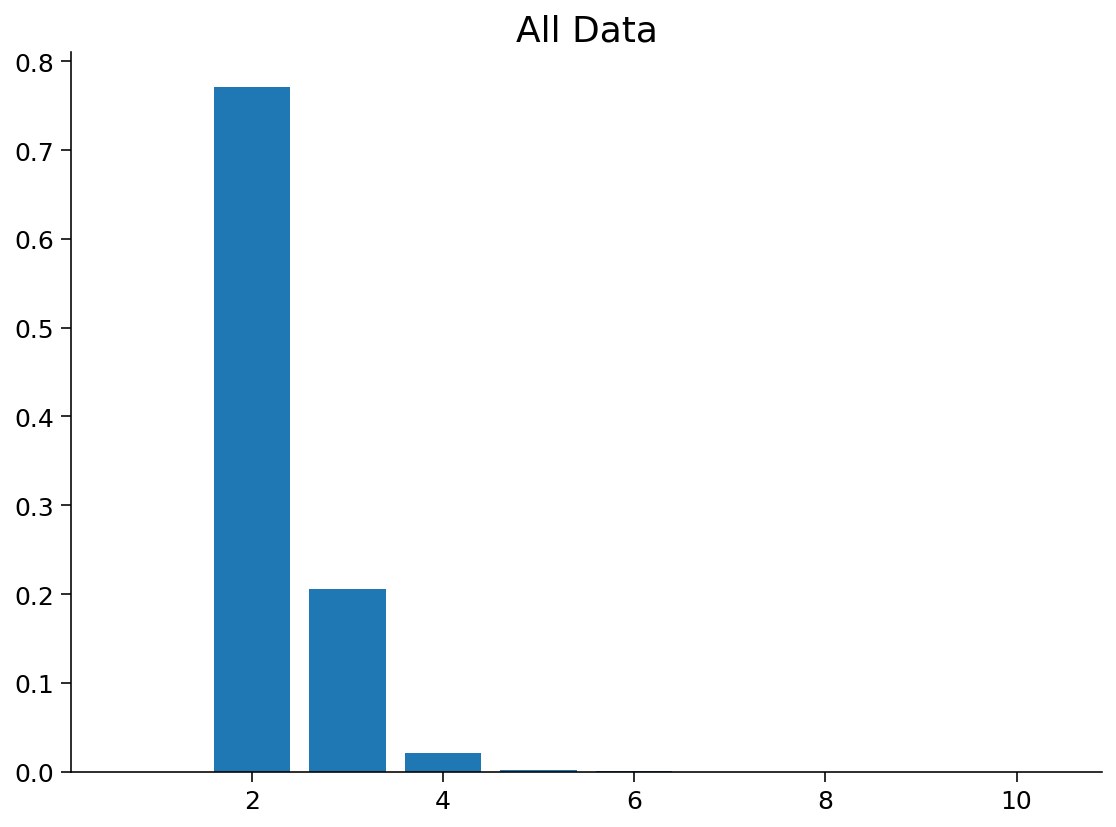

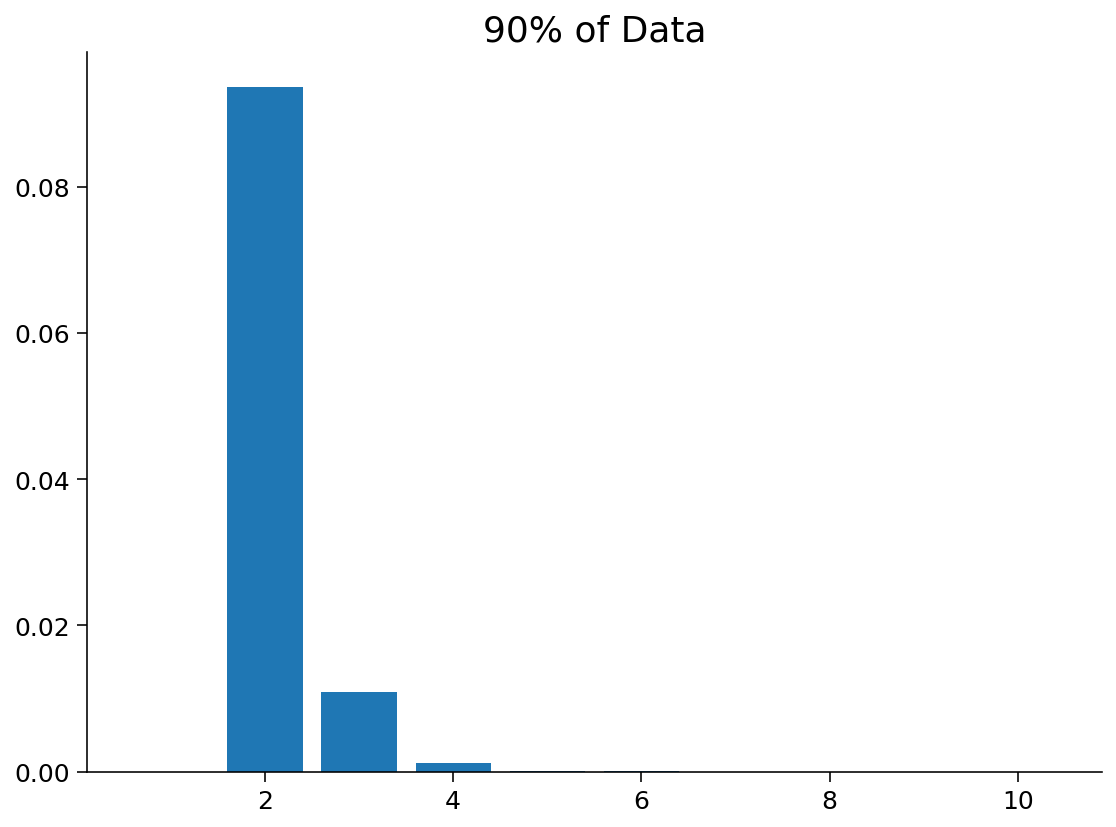

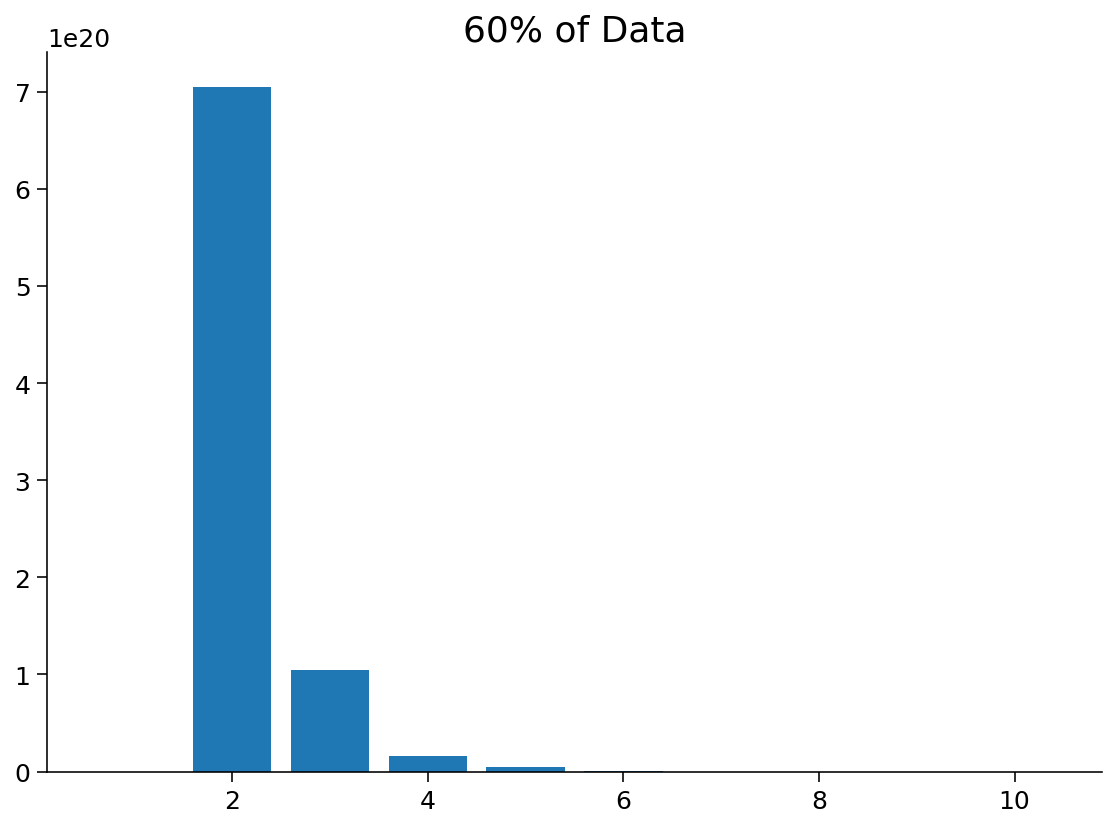

In [ ]:
#Type your code for Question #11 here
from sklearn.preprocessing import normalize
x = np.arange(-5,5,.1)
sigma = 1
y = output_quadratic(x,sigma)
xs = np.arange(1,11)


# All Data
bics = []
summation_b = 0
for i in range(1,11):
  lhood = calculateLikelihood(x,y,i)
  bic = -2 * lhood + i * np.log(len(x))
  bic_num = np.exp((-1/2) * bic)
  summation_b += bic_num
  bics.append(bic_num)


priors = [bic_num / summation_b for bic_num in bics]
print(len(priors))
print(priors)
plt.bar(xs, priors)
plt.title("All Data")

# 90% Data
bicnums_90 = [np.exp((-1/2) * bic) for bic in bic_90]
summation_b90 = sum(bicnums_90)
priors_90 = [bic_num / summation_b for bic_num in bicnums_90]
plt.figure()
plt.bar(xs, priors_90)
plt.title("90% of Data")

# 60% Data
bicnums_60 = [np.exp((-1/2) * bic) for bic in bic_60]
summation_b60 = sum(bicnums_60)
priors_60 = [bic_num / summation_b for bic_num in bicnums_60]
plt.figure()
plt.bar(xs, priors_60)
plt.title("60% of Data")


<font color=green> Are your results more or less certain as you increase the number of data points? 

More certain. </font>

##Fitting unknown data

For this portion of the exercise, you will now be given data from an unknown polynomial that has been corrupted with an unknown amount of noise.  Run the code below to import the data.  ```x``` are the x-axis values, and ```y1```, ```y2```, and ```y3``` are three different instantiations of the data set (same polynomial, same amount of noise).

In [ ]:
url = 'https://raw.githubusercontent.com/gordonberman/bioqtm385_fall2020/master/data/test_data.csv'
test_data_df = pd.read_csv(url,header=None)
test_data = test_data_df.to_numpy()
x = test_data[:,0]
y1 = test_data[:,1]
y2 = test_data[:,2]
y3 = test_data[:,3]

<font color="blue">Question #12: Using the data above, what can you say about the underlying polynomial that generated the data?  Use model-selection-based arguments to back-up your assertions.</font>

1 mean: Test - 17041.605575434445 | Train - 140267.30488534382
   std: Test - 8021.684422756385 | Train - 7655.383053042645
2 mean: Test - 13982.340697385218 | Train - 115978.88924881557
   std: Test - 5413.109379239606 | Train - 5110.185873080752
3 mean: Test - 6332.069785260355 | Train - 51132.54520475552
   std: Test - 2645.6292468815363 | Train - 2472.2398077799216
4 mean: Test - 5433.820073332003 | Train - 43984.254209663166
   std: Test - 2338.976077298295 | Train - 2197.0001389893187
5 mean: Test - 5001.874183752536 | Train - 40375.00671962184
   std: Test - 1962.8265747722714 | Train - 1834.319841906096
6 mean: Test - 5161.993895199283 | Train - 40230.02073554561
   std: Test - 2080.8819238864894 | Train - 1916.560594426538
7 mean: Test - 5355.052732106301 | Train - 40096.6393166524
   std: Test - 2115.275938133882 | Train - 1923.8396479725827
8 mean: Test - 5360.7805902109285 | Train - 40163.604688328924
   std: Test - 2149.709874303059 | Train - 1915.219640020803
9 mean: Test

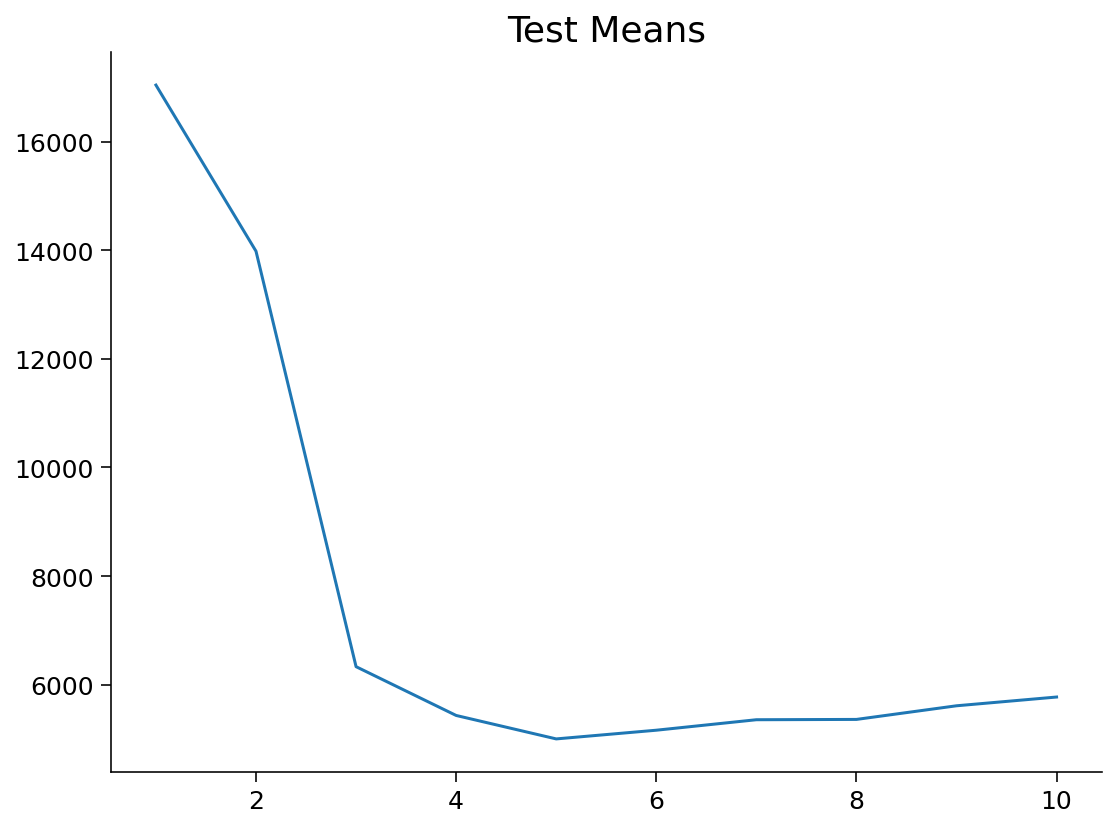

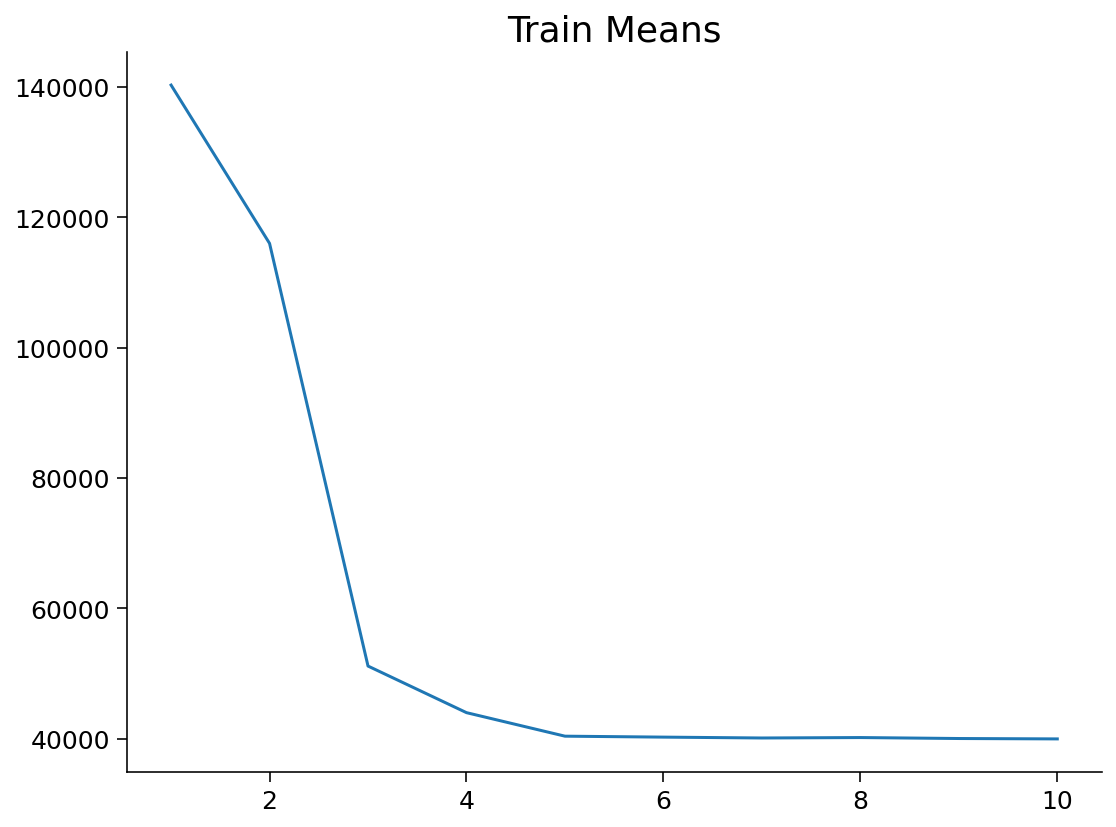

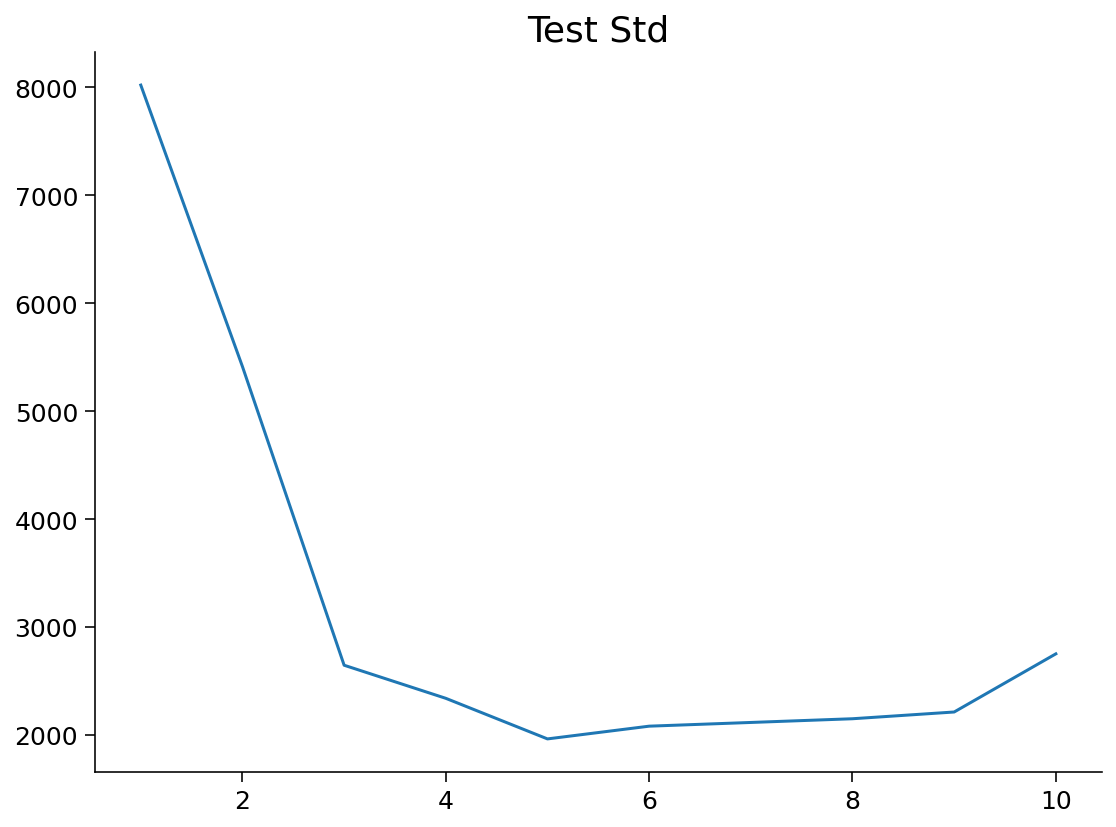

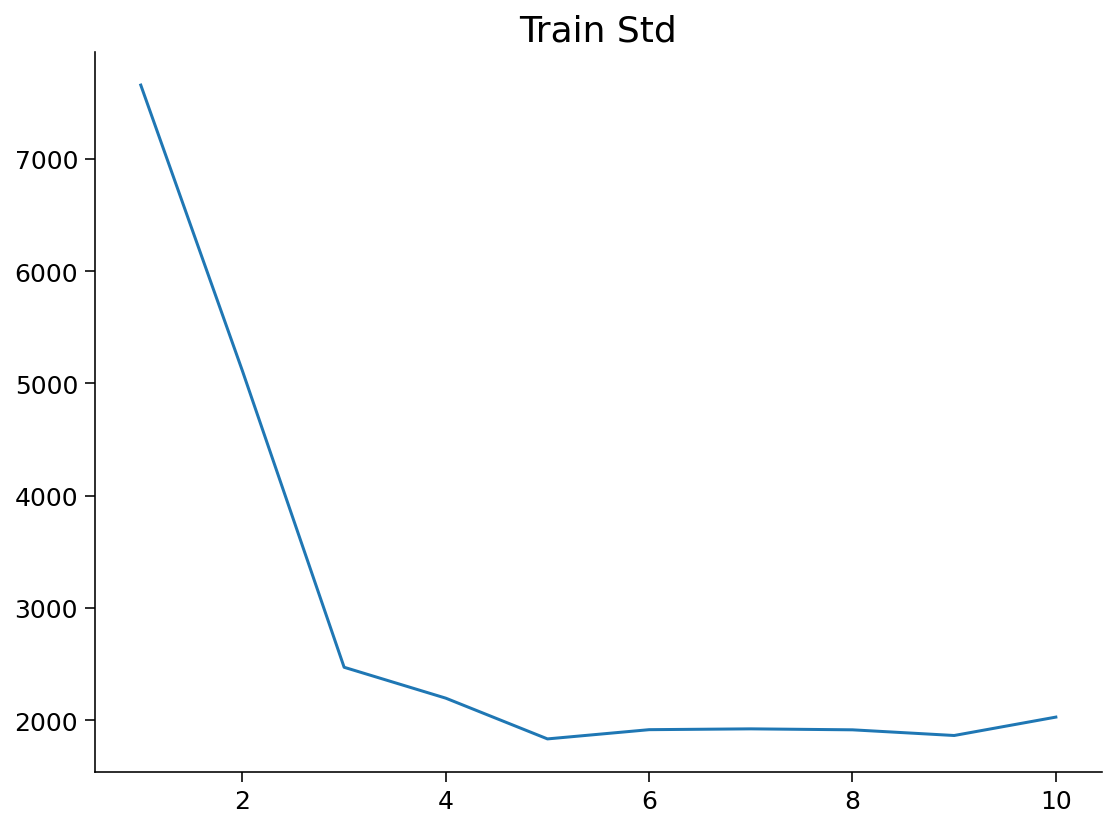

Order: 1, AIC: 1021.5750586185428
Order: 2, AIC: 1004.3476124940568
Order: 3, AIC: 924.583426752995
Order: 4, AIC: 911.4620575667187
Order: 5, AIC: 904.8851489165595
Order: 6, AIC: 906.7558216085203
Order: 7, AIC: 908.6964534978445
Order: 8, AIC: 910.6896299153547
Order: 9, AIC: 912.6146937032398
Order: 10, AIC: 914.5366023606201
10
[6.677875379341773e-24, 9.995975582472181e-21, 0.0005684503378247191, 0.10920842081497177, 0.7956245519055744, 0.08487723913899672, 0.008743450707008351, 0.0008773332481783494, 9.108288533110723e-05, 9.470962114665692e-06]


Text(0.5, 1.0, 'All Data')

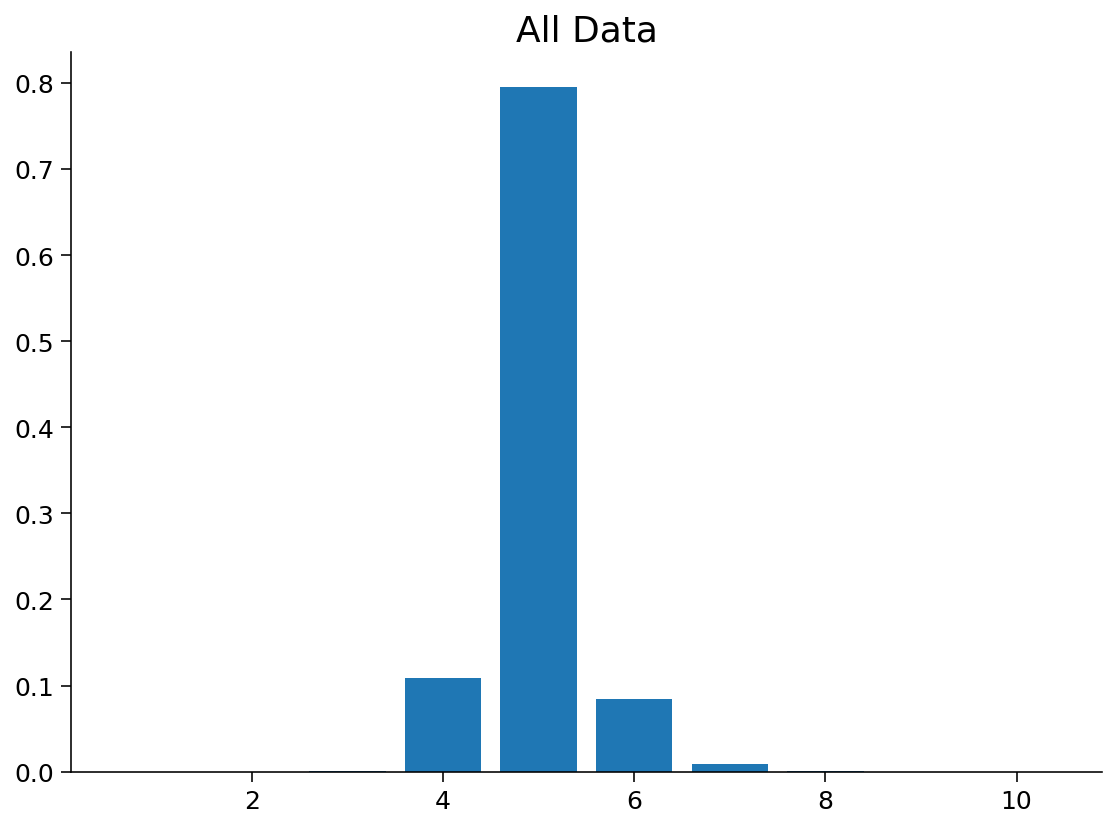

In [ ]:
#Type your code for Question #12 here

## Checking Bias and Variance at various orders.
fit_mses = []
for fit in range(1, 11):
  sigma = 1
  L = 90
  test_mses = []
  train_mses = []
  for i in range(1000):
    y = output_quadratic(x,sigma)
    idx = np.arange(np.shape(x)[0])
    random.shuffle(idx) 
    x_train = x[idx[:L]]
    y_train = y1[idx[:L]]
    x_test = x[idx[L:]]
    y_test = y1[idx[L:]]

    cubic = np.polyfit(x_train,y_train,fit)
    cubic_y = np.polyval(cubic, x_train)
    train_mse = sum((cubic_y - y_train) ** 2)
    train_mses.append(train_mse)

    cubic_test_y = np.polyval(cubic, x_test)
    test_mse = sum((cubic_test_y - y_test) ** 2)

    test_mses.append(test_mse)

  fit_mses.append((test_mses, train_mses))

test_means = []
train_means = []
test_sds = []
train_sds = []
for i, vals in enumerate(fit_mses):
  test, train = vals
  test_mean = np.mean(test)
  train_mean = np.mean(train)
  test_means.append(test_mean)
  train_means.append(train_mean)

  test_sd = np.std(test)
  train_sd = np.std(train)
  test_sds.append(test_sd)
  train_sds.append(train_sd)

  print("{} mean: Test - {} | Train - {}".format(i+1,test_mean, train_mean))
  print("   std: Test - {} | Train - {}".format(test_sd, train_sd))

x_s = np.arange(1,11)
plt.errorbar(x_s, test_means)
plt.title("Test Means")
plt.figure()
plt.errorbar(x_s, train_means)
plt.title("Train Means")
plt.figure()
plt.errorbar(x_s, test_sds)
plt.title("Test Std")
plt.figure()
plt.errorbar(x_s, train_sds)
plt.title("Train Std")
plt.show()

## Check AIC
for i in range(1,11):
  lhood = calculateLikelihood(x,y1,i)
  aic = -2 * lhood + 2 * i
  print("Order: {}, AIC: {}".format(i, aic))


## Check BIC
bics = []
summation_b = 0
for i in range(1,11):
  lhood = calculateLikelihood(x,y1,i)
  bic = -2 * lhood + i * np.log(len(x))
  bic_num = np.exp((-1/2) * bic)
  summation_b += bic_num
  bics.append(bic_num)


priors = [bic_num / summation_b for bic_num in bics]
print(len(priors))
print(priors)
plt.bar(x_s, priors)
plt.title("All Data")

<font color=green> What can you say about the underlying polynomial that generated the data? Use model-selection-based arguments to back-up your assertions. 

Since the graph shows that it has the lowest bias/variance in the MSE at 5, the data seems to be generated by a 5th-order polynomial. This implies that AIC is at its lowest at 5 and BIC is at its highest at 5.

</font>

##Spike sorting revisited

Use this code to load the spiking data from in-class exercise 3b.

In [ ]:
url = 'https://raw.githubusercontent.com/gordonberman/bioqtm385_fall2020/master/data/spike_data.csv'
spike_data_df = pd.read_csv(url,header=None)
spike_data = spike_data_df.to_numpy()

<font color=blue> Question #13: Revisit Question #2 from in-class exercise 3b.  Knowing what you know now, use ideas from model selection to estimate the number of neurons in the data set.  Justify your answer.  Note that ```aic``` and ```bic``` can be [calculated](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) directly from GaussianMixture fits.

Text(0.5, 0, 'n_components')

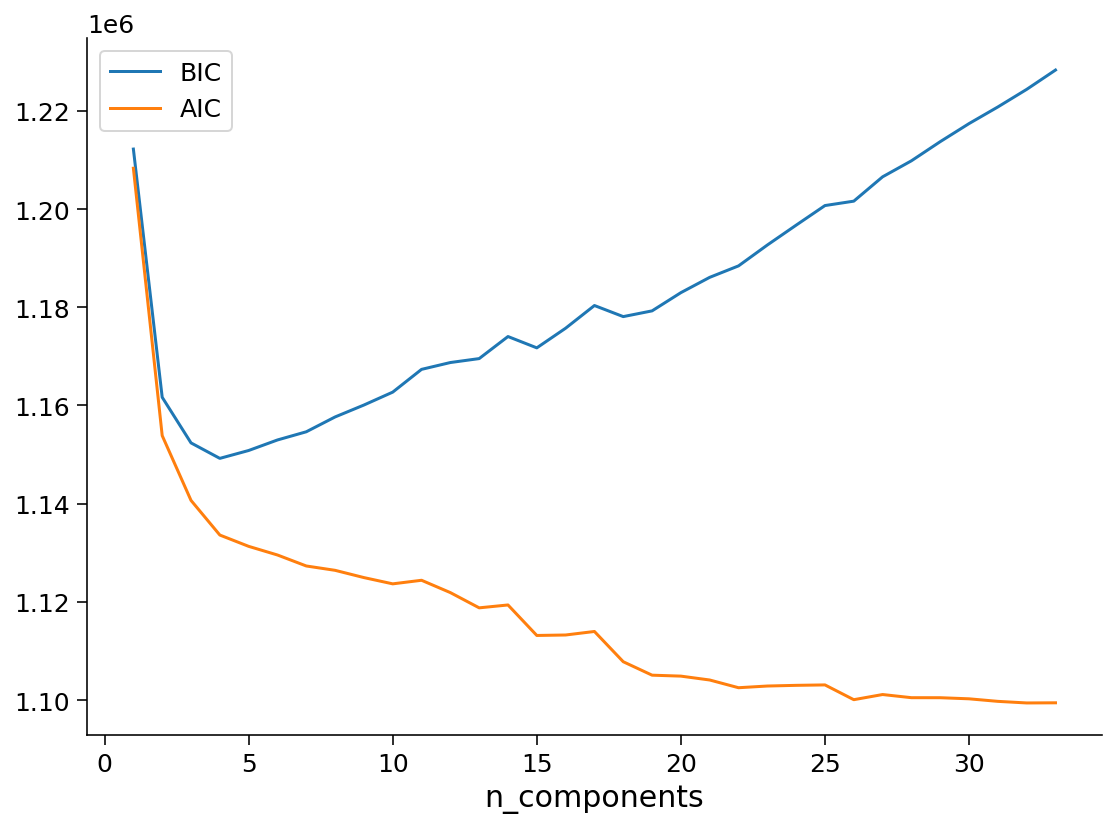

In [ ]:
n_components = np.arange(1, 34)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(spike_data)
          for n in n_components]


plt.plot(n_components, [m.bic(spike_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(spike_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

<font color="green"> Knowing what you know now, use ideas from model selection to estimate the number of neurons in the data set. Justify your answer.  

About 4 types of neurons. This is becasue the BIC curve has the minimum n components around 4.
</font>